<a href="https://colab.research.google.com/github/I8KIDZ/cloudass/blob/main/BDNS_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unzipping and Checking Data**

In [3]:
!unzip -o Dataset.zip -d /content/

unzip:  cannot find or open Dataset.zip, Dataset.zip.zip or Dataset.zip.ZIP.


In [4]:
import pandas as pd

# Load the datasets
trip_df = pd.read_csv('/content/taxi_trip_data.csv')
zone_df = pd.read_csv('/content/taxi_zone_geo.csv')

# Show basic info
print("Trip Data Info:")
print(trip_df.info())
print("\nTrip Data Sample:")
print(trip_df.head())

print("\nZone Data Info:")
print(zone_df.info())
print("\nZone Data Sample:")
print(zone_df.head())

Trip Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197842 entries, 0 to 197841
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   vendor_id            197842 non-null  int64  
 1   pickup_datetime      197842 non-null  object 
 2   dropoff_datetime     197842 non-null  object 
 3   passenger_count      197842 non-null  int64  
 4   trip_distance        197842 non-null  float64
 5   rate_code            197842 non-null  int64  
 6   store_and_fwd_flag   197842 non-null  object 
 7   payment_type         197842 non-null  int64  
 8   fare_amount          197842 non-null  float64
 9   extra                197842 non-null  float64
 10  mta_tax              197842 non-null  float64
 11  tip_amount           197841 non-null  float64
 12  tolls_amount         197841 non-null  float64
 13  imp_surcharge        197841 non-null  float64
 14  pickup_location_id   197841 non-null  float64
 15  d

In [5]:
# Check for nulls and zero values
print("trip_df")
print("Missing values:\n", trip_df.isnull().sum())
print("\nZero values:\n", (trip_df == 0).sum())
print("\n")
print("zone_df")
print("Missing values:\n", zone_df.isnull().sum())
print("\nZero values:\n", (zone_df == 0).sum())

trip_df
Missing values:
 vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
rate_code              0
store_and_fwd_flag     0
payment_type           0
fare_amount            0
extra                  0
mta_tax                0
tip_amount             1
tolls_amount           1
imp_surcharge          1
pickup_location_id     1
dropoff_location_id    1
dtype: int64

Zero values:
 vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count          1750
trip_distance            1338
rate_code                   0
store_and_fwd_flag          0
payment_type                0
fare_amount                43
extra                  105347
mta_tax                   840
tip_amount              67349
tolls_amount           186954
imp_surcharge              59
pickup_location_id          0
dropoff_location_id         0
dtype: int64


zone_df
Missing values:
 zone_id      0
zone_name   

In [6]:
# Check duplicates in both
trip_dups = trip_df.duplicated()
zone_dups = zone_df.duplicated()

# Report
print(f"Trip Data: {trip_dups.sum()} duplicate rows")
print(f"Zone Data: {zone_dups.sum()} duplicate rows")

Trip Data: 32 duplicate rows
Zone Data: 0 duplicate rows


# **zone_df dataset has no duplicates, null or missing values. Hence it needs no cleaning.**

# **1. Data Cleaning & Engineering**

In [7]:
# Clean zero-value records
initial_rows = trip_df.shape[0]

trip_df = trip_df[
    (trip_df['passenger_count'] > 0) &
    (trip_df['trip_distance'] > 0) &
    (trip_df['fare_amount'] > 0)
]

print(f"Rows before cleaning: {initial_rows}")
print(f"Rows after cleaning: {trip_df.shape[0]}")

Rows before cleaning: 197842
Rows after cleaning: 194654


In [8]:
# Drop duplicates
before_dedup = trip_df.shape[0]
trip_df = trip_df.drop_duplicates()
after_dedup = trip_df.shape[0]
print(f"Removed duplicates: {before_dedup - after_dedup}")

# Drop irrelevant columns
columns_to_drop = ['store_and_fwd_flag']
trip_df = trip_df.drop(columns=columns_to_drop)

# Confirm new shape
print("Remaining columns:", trip_df.columns.tolist())

Removed duplicates: 32
Remaining columns: ['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'rate_code', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'pickup_location_id', 'dropoff_location_id']


In [9]:
# Convert to datetime
trip_df['pickup_datetime'] = pd.to_datetime(trip_df['pickup_datetime'])
trip_df['dropoff_datetime'] = pd.to_datetime(trip_df['dropoff_datetime'])

# Compute trip duration
trip_df['trip_duration_minutes'] = (trip_df['dropoff_datetime'] - trip_df['pickup_datetime']).dt.total_seconds() / 60

# Filter out negative or 0 durations
before_filter = trip_df.shape[0]
trip_df = trip_df[trip_df['trip_duration_minutes'] > 0]
after_filter = trip_df.shape[0]

print(f"Removed {before_filter - after_filter} rows with non-positive durations")
print(trip_df[['pickup_datetime', 'dropoff_datetime', 'trip_duration_minutes']].head())

Removed 317 rows with non-positive durations
      pickup_datetime    dropoff_datetime  trip_duration_minutes
0 2018-05-11 17:40:00 2018-05-11 17:55:00                   15.0
1 2018-03-22 23:01:00 2018-03-22 23:25:00                   24.0
2 2018-07-24 09:58:00 2018-07-24 10:22:00                   24.0
3 2018-12-21 18:28:00 2018-12-21 18:35:00                    7.0
4 2018-08-15 13:58:00 2018-08-15 14:05:00                    7.0


In [10]:
# Compute total trip cost
trip_df.loc[:, 'total_trip_cost'] = (
    trip_df['fare_amount'] +
    trip_df['extra'] +
    trip_df['mta_tax'] +
    trip_df['tip_amount'] +
    trip_df['tolls_amount'] +
    trip_df['imp_surcharge']
)

# Preview
print(trip_df[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_trip_cost']].head())

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  total_trip_cost
0         11.5    1.0      0.5        0.00           0.0            13.30
1         28.5    0.5      0.5        5.96           0.0            35.76
2         15.5    0.0      0.5        1.50           0.0            17.80
3          6.0    1.0      0.5        0.00           0.0             7.80
4          5.5    0.0      0.5        0.00           0.0             6.30


<ipython-input-10-7e1e5fcf5136>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_df.loc[:, 'total_trip_cost'] = (


In [11]:
# Rename for merging
pickup_zone_df = zone_df.rename(columns={
    'zone_id': 'pickup_location_id',
    'zone_name': 'pickup_zone',
    'borough': 'pickup_borough'
}).drop(columns=['zone_geom'])

dropoff_zone_df = zone_df.rename(columns={
    'zone_id': 'dropoff_location_id',
    'zone_name': 'dropoff_zone',
    'borough': 'dropoff_borough'
}).drop(columns=['zone_geom'])

# Merge with trip data
trip_df = trip_df.merge(pickup_zone_df, on='pickup_location_id', how='left')
trip_df = trip_df.merge(dropoff_zone_df, on='dropoff_location_id', how='left')

# Show confirmation
print(trip_df[['pickup_location_id', 'pickup_zone', 'pickup_borough', 'dropoff_location_id', 'dropoff_zone', 'dropoff_borough']].head())

   pickup_location_id          pickup_zone pickup_borough  \
0                48.0         Clinton East      Manhattan   
1               138.0    LaGuardia Airport         Queens   
2               234.0             Union Sq      Manhattan   
3                79.0         East Village      Manhattan   
4               233.0  UN/Turtle Bay South      Manhattan   

   dropoff_location_id               dropoff_zone dropoff_borough  
0                 68.0               East Chelsea       Manhattan  
1                230.0  Times Sq/Theatre District       Manhattan  
2                 48.0               Clinton East       Manhattan  
3                125.0                  Hudson Sq       Manhattan  
4                233.0        UN/Turtle Bay South       Manhattan  


In [12]:
# Check for nulls and zero values
print("trip_df")
print("Missing values:\n", trip_df.isnull().sum())
print("\nZero values:\n", (trip_df == 0).sum())
print("\n")
print("zone_df")
print("Missing values:\n", zone_df.isnull().sum())
print("\nZero values:\n", (zone_df == 0).sum())

trip_df
Missing values:
 vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_distance               0
rate_code                   0
payment_type                0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  1
tolls_amount                1
imp_surcharge               1
pickup_location_id          1
dropoff_location_id         1
trip_duration_minutes       0
total_trip_cost             1
pickup_zone              2883
pickup_borough           2883
dropoff_zone             2927
dropoff_borough          2927
dtype: int64

Zero values:
 vendor_id                     0
pickup_datetime               0
dropoff_datetime              0
passenger_count               0
trip_distance                 0
rate_code                     0
payment_type                  0
fare_amount                   0
extra                    103177
mta_tax                     5

In [13]:
# Drop trips with missing zone/borough info
before_dropna = trip_df.shape[0]
trip_df = trip_df.dropna(subset=['pickup_zone', 'dropoff_zone'])
after_dropna = trip_df.shape[0]

print(f"Removed {before_dropna - after_dropna} rows with missing pickup/dropoff zone data")

Removed 3309 rows with missing pickup/dropoff zone data


In [14]:
trip_df

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,payment_type,fare_amount,extra,mta_tax,...,tolls_amount,imp_surcharge,pickup_location_id,dropoff_location_id,trip_duration_minutes,total_trip_cost,pickup_zone,pickup_borough,dropoff_zone,dropoff_borough
0,1,2018-05-11 17:40:00,2018-05-11 17:55:00,1,1.60,1,1,11.5,1.0,0.5,...,0.0,0.3,48.0,68.0,15.0,13.30,Clinton East,Manhattan,East Chelsea,Manhattan
1,2,2018-03-22 23:01:00,2018-03-22 23:25:00,1,9.52,1,1,28.5,0.5,0.5,...,0.0,0.3,138.0,230.0,24.0,35.76,LaGuardia Airport,Queens,Times Sq/Theatre District,Manhattan
2,2,2018-07-24 09:58:00,2018-07-24 10:22:00,1,2.17,1,1,15.5,0.0,0.5,...,0.0,0.3,234.0,48.0,24.0,17.80,Union Sq,Manhattan,Clinton East,Manhattan
3,2,2018-12-21 18:28:00,2018-12-21 18:35:00,1,0.86,1,2,6.0,1.0,0.5,...,0.0,0.3,79.0,125.0,7.0,7.80,East Village,Manhattan,Hudson Sq,Manhattan
4,1,2018-08-15 13:58:00,2018-08-15 14:05:00,1,0.30,1,2,5.5,0.0,0.5,...,0.0,0.3,233.0,233.0,7.0,6.30,UN/Turtle Bay South,Manhattan,UN/Turtle Bay South,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194356,2,2018-08-30 20:42:00,2018-08-30 21:14:00,1,6.71,1,1,25.5,0.5,0.5,...,0.0,0.3,236.0,244.0,32.0,29.00,Upper East Side North,Manhattan,Washington Heights South,Manhattan
194357,1,2018-02-13 21:56:00,2018-02-13 21:59:00,1,0.70,1,3,4.5,0.5,0.5,...,0.0,0.3,234.0,113.0,3.0,5.80,Union Sq,Manhattan,Greenwich Village North,Manhattan
194358,1,2018-05-16 22:02:00,2018-05-16 22:26:00,1,4.20,1,1,19.0,0.5,0.5,...,0.0,0.3,107.0,261.0,24.0,24.35,Gramercy,Manhattan,World Trade Center,Manhattan
194359,2,2018-08-23 22:16:00,2018-08-23 22:24:00,1,1.36,1,1,7.0,0.5,0.5,...,0.0,0.3,144.0,261.0,8.0,10.38,Little Italy/NoLiTa,Manhattan,World Trade Center,Manhattan


In [15]:
trip_df[["trip_duration_minutes", "trip_distance", "fare_amount"]].describe()

,trip_duration_minutes,trip_distance,fare_amount
count,191053.000000,191053.000000,191053.000000
mean,17.630741,2.920312,12.791720
std,67.915319,3.685020,10.548982
min,1.000000,0.010000,0.010000
25%,7.000000,0.990000,6.500000
50%,11.000000,1.610000,9.500000
75%,18.000000,3.000000,14.500000
max,1440.000000,47.350000,150.000000


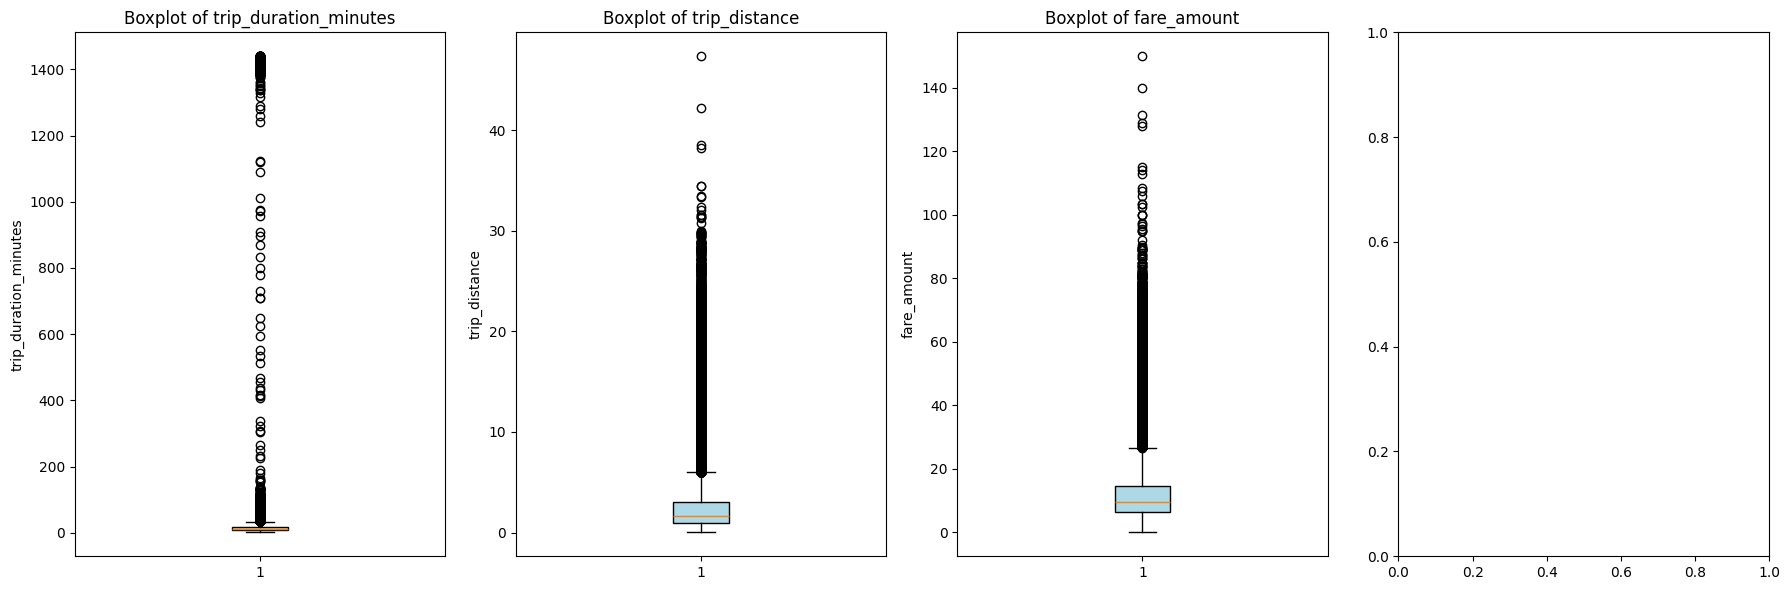

In [16]:
import matplotlib.pyplot as plt

# Define columns to plot
columns = ["trip_duration_minutes", "trip_distance", "fare_amount"]

# Set up box plots
fig, axs = plt.subplots(1, 4, figsize=(18, 6))

for i, col in enumerate(columns):
    axs[i].boxplot(trip_df[col], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[i].set_title(f"Boxplot of {col}")
    axs[i].set_ylabel(col)

plt.tight_layout()
plt.show()

# **OUTLIERS GO BRRRRRRRR 🔥🔥🔥**

In [17]:
# For trip_df
print("trip_df numeric columns:")
print(trip_df.select_dtypes(include='number').columns.tolist())

# For zone_df
print("zone_df numeric columns:")
print(zone_df.select_dtypes(include='number').columns.tolist())

trip_df numeric columns:
['vendor_id', 'passenger_count', 'trip_distance', 'rate_code', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'pickup_location_id', 'dropoff_location_id', 'trip_duration_minutes', 'total_trip_cost']
zone_df numeric columns:
['zone_id']


In [18]:
iqr_columns = [
    "trip_duration_minutes",
    "trip_distance",
    "fare_amount",
    "tip_amount",
    "tolls_amount",
    "total_trip_cost"
]

In [19]:
def remove_iqr_outliers_all(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Apply to selected real-valued features
trip_df_cleaned = remove_iqr_outliers_all(trip_df, iqr_columns)
print("Remaining rows after full-feature IQR cleaning:", trip_df_cleaned.shape[0])

Remaining rows after full-feature IQR cleaning: 158688


# **2. Analytical Queries**

In [20]:
from pyspark.sql.functions import hour, when, col, count, row_number
from pyspark.sql.window import Window

In [21]:
# Start Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BDNS A3") \
    .getOrCreate()

In [22]:
# Convert trip_df to Spark DataFrame

trip_sdf = spark.createDataFrame(trip_df)

In [23]:
# a) What is the most common payment type used per time of day (morning, afternoon, evening)?

# Add pickup_hour and time_of_day
trip_sdf = trip_sdf.withColumn("pickup_hour", hour("pickup_datetime"))
trip_sdf = trip_sdf.withColumn(
    "time_of_day",
    when((col("pickup_hour") >= 5) & (col("pickup_hour") <= 11), "Morning")
    .when((col("pickup_hour") >= 12) & (col("pickup_hour") <= 16), "Afternoon")
    .when((col("pickup_hour") >= 17) & (col("pickup_hour") <= 21), "Evening")
    .otherwise("Night")
)

# Count number of trips by time_of_day and payment_type
payment_counts = trip_sdf.groupBy("time_of_day", "payment_type") \
                         .agg(count("*").alias("trip_count"))

# Extract the most frequent payment type per time_of_day
window_spec = Window.partitionBy("time_of_day").orderBy(col("trip_count").desc())
most_common_payment = payment_counts.withColumn("rank", row_number().over(window_spec)) \
                                    .filter(col("rank") == 1) \
                                    .select("time_of_day", "payment_type", "trip_count")

most_common_payment.show()

+-----------+------------+----------+
|time_of_day|payment_type|trip_count|
+-----------+------------+----------+
|  Afternoon|           1|     33122|
|    Evening|           1|     40466|
|    Morning|           1|     34605|
|      Night|           1|     24746|
+-----------+------------+----------+



In [24]:
# b) Which boroughs generate the highest total revenue based on pickup locations,
# and how do they compare in terms of trip volume?

from pyspark.sql.functions import sum as _sum

# Group by pickup borough, compute total revenue and trip count
borough_stats = trip_sdf.groupBy("pickup_borough") \
    .agg(
        _sum("total_trip_cost").alias("total_revenue"),
        count("*").alias("trip_count")
    ) \
    .orderBy(col("total_revenue").desc())

borough_stats.show()

+--------------+------------------+----------+
|pickup_borough|     total_revenue|trip_count|
+--------------+------------------+----------+
|     Manhattan|2498474.1400021147|    176450|
|        Queens| 529155.1699999792|     11995|
|      Brooklyn| 43448.69999999947|      2409|
|         Bronx| 5133.759999999999|       197|
| Staten Island|             25.82|         1|
|           EWR|              14.3|         1|
+--------------+------------------+----------+



In [25]:
# c) What is the average tip amount per passenger count?

from pyspark.sql.functions import avg

# Group by passenger count and compute average tip
avg_tip_by_passenger = trip_sdf.groupBy("passenger_count") \
    .agg(avg("tip_amount").alias("avg_tip_amount")) \
    .orderBy("passenger_count")

avg_tip_by_passenger.show()

+---------------+------------------+
|passenger_count|    avg_tip_amount|
+---------------+------------------+
|              1|1.8510339893710785|
|              2|1.8483348649795004|
|              3|1.8192172162094145|
|              4|1.7345831188883194|
|              5|1.8644476277790523|
|              6|1.8867273424027589|
+---------------+------------------+



In [26]:
# d) What are the best 5 locations for drivers to pick up passengers from and at which time of the day?

from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

# Count number of pickups per zone per time of day
pickup_counts = trip_sdf.groupBy("pickup_zone", "time_of_day") \
                        .agg(count("*").alias("trip_count"))

# Rank pickups by trip count within each time_of_day
window_spec = Window.partitionBy("time_of_day").orderBy(col("trip_count").desc())
top_pickups = pickup_counts.withColumn("rank", row_number().over(window_spec)) \
                           .filter(col("rank") <= 5) \
                           .orderBy("time_of_day", "rank")

top_pickups.select("time_of_day", "pickup_zone", "trip_count").show(20, truncate=False)

+-----------+----------------------------+----------+
|time_of_day|pickup_zone                 |trip_count|
+-----------+----------------------------+----------+
|Afternoon  |Upper East Side South       |2633      |
|Afternoon  |Upper East Side North       |2518      |
|Afternoon  |Midtown Center              |2235      |
|Afternoon  |Midtown East                |1777      |
|Afternoon  |Union Sq                    |1692      |
|Evening    |Midtown East                |2460      |
|Evening    |Midtown Center              |2450      |
|Evening    |Upper East Side South       |2423      |
|Evening    |Times Sq/Theatre District   |2088      |
|Evening    |Union Sq                    |2087      |
|Morning    |Upper East Side North       |2445      |
|Morning    |Upper East Side South       |2204      |
|Morning    |Penn Station/Madison Sq West|2166      |
|Morning    |Murray Hill                 |1801      |
|Morning    |Clinton East                |1723      |
|Night      |East Village   

In [27]:
# e) What are the top 5 longest trips recorded in the dataset and display their corresponding trip
# duration, fare, pickup and dropoff zones, and payment type. Comment on whether these trips also
# resulted in high fares or if any anomalies are observed.

# Select and sort by longest duration
longest_trips = trip_sdf.select(
    "trip_duration_minutes",
    "fare_amount",
    "pickup_zone",
    "dropoff_zone",
    "payment_type"
).orderBy(col("trip_duration_minutes").desc()).limit(5)

longest_trips.show(truncate=False)

+---------------------+-----------+---------------------+---------------------+------------+
|trip_duration_minutes|fare_amount|pickup_zone          |dropoff_zone         |payment_type|
+---------------------+-----------+---------------------+---------------------+------------+
|1440.0               |15.5       |Upper East Side North|Gramercy             |1           |
|1440.0               |6.5        |Yorkville West       |Upper West Side South|2           |
|1440.0               |7.0        |Lenox Hill East      |Upper East Side North|1           |
|1440.0               |12.0       |Gramercy             |Lower East Side      |1           |
|1440.0               |52.0       |JFK Airport          |Upper East Side North|2           |
+---------------------+-----------+---------------------+---------------------+------------+



All five longest trips have an exact duration of 1440 minutes (24 hours). While the zones and fares vary, the fixed max duration suggests a system constraint or timestamp issue.
Several trips occurred within small local zones (e.g., Lenox Hill to Lenox Hill), yet report a 24-hour duration with very low fares, which is logically inconsistent.
These likely represent data edge cases, not actual long trips, though they passed validation during earlier cleaning.

In [28]:
# f) Which pickup and drop-off borough combinations represent the most frequent inter-borough travel
# flows? Present the top routes by trip count, and optionally include revenue per route.

# Filter inter-borough trips only
inter_borough = trip_sdf.filter(col("pickup_borough") != col("dropoff_borough"))

# Group by pickup → dropoff borough and count trips and revenue
route_stats = inter_borough.groupBy("pickup_borough", "dropoff_borough") \
    .agg(
        count("*").alias("trip_count"),
        _sum("total_trip_cost").alias("total_revenue")
    ) \
    .orderBy(col("trip_count").desc())

route_stats.show(truncate=False)

+--------------+---------------+----------+------------------+
|pickup_borough|dropoff_borough|trip_count|total_revenue     |
+--------------+---------------+----------+------------------+
|Queens        |Manhattan      |7153      |372767.7599999956 |
|Manhattan     |Queens         |6032      |255623.86000000156|
|Manhattan     |Brooklyn       |5121      |144888.41000000277|
|Queens        |Brooklyn       |1711      |79548.90000000008 |
|Manhattan     |Bronx          |903       |29045.80999999985 |
|Brooklyn      |Manhattan      |721       |17978.900000000016|
|Manhattan     |EWR            |350       |33865.49999999997 |
|Queens        |Bronx          |189       |10469.610000000008|
|Brooklyn      |Queens         |146       |4859.56           |
|Bronx         |Manhattan      |81        |2140.199999999999 |
|Manhattan     |Staten Island  |23        |1855.62           |
|Brooklyn      |Bronx          |17        |1069.76           |
|Bronx         |Brooklyn       |13        |888.09      

# **3. SparkML Task: Trip Profiling: Predict Likelihood of High Tipping**

In [29]:
# Tamer

In [30]:
# Yehia

Imports & Spark session

In [31]:
# Ahmed
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
spark = SparkSession.builder.appName("HighTipPrediction").getOrCreate()

Load cleaned DataFrame

In [32]:
sdf = spark.createDataFrame(trip_df)


the binary label

In [33]:
sdf = sdf.withColumn(
    "high_tip",
    F.when(F.col("tip_amount") > 0.15 * F.col("fare_amount"), 1).otherwise(0)
)


Feature engineering

In [34]:
sdf = sdf \
  .withColumn("pickup_hour", F.hour("pickup_datetime")) \
  .withColumn("trip_duration_minutes", F.col("trip_duration_minutes")) \
  .withColumn("fare_per_mile", F.col("fare_amount") / F.col("trip_distance"))

feature_cols = [
  "passenger_count",
  "trip_distance",
  "trip_duration_minutes",
  "pickup_hour",
  "fare_amount",
  "fare_per_mile"
]


VectorAssembler + Train/Test split

In [35]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train, test = sdf.randomSplit([0.8, 0.2], seed=42)


 train your three classifiers

In [36]:
models = [
  ("LR",        LogisticRegression(labelCol="high_tip", featuresCol="features")),
  ("DT",        DecisionTreeClassifier(labelCol="high_tip", featuresCol="features")),
  ("RF",        RandomForestClassifier(labelCol="high_tip", featuresCol="features", numTrees=50))
]

evaluator_acc = MulticlassClassificationEvaluator(labelCol="high_tip", predictionCol="prediction", metricName="accuracy")
evaluator_roc = BinaryClassificationEvaluator(labelCol="high_tip", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

results = []
for name, clf in models:
    pipeline = Pipeline(stages=[assembler, clf])
    mdl = pipeline.fit(train)
    preds = mdl.transform(test)
    results.append({
        "model": name,
        "accuracy": evaluator_acc.evaluate(preds),
        "AUC":      evaluator_roc.evaluate(preds),
        # and for tree‐based:
        "features_imp": getattr(mdl.stages[-1], "featureImportances", None)
    })


In [39]:
# After training each model and computing preds:
if hasattr(mdl.stages[-1], "featureImportances"):
    # Convert to a Python list of floats
    fi_list = mdl.stages[-1].featureImportances.toArray().tolist()
    # Pair with feature names and sort descending
    fi_pairs = sorted(zip(feature_cols, fi_list), key=lambda x: -x[1])

    print("Feature Importances:")
    for feat, score in fi_pairs:
        # score is now a native float
        print(f"  {feat:25s} {score:.3f}")

for r in results:
    print(f"{r['model']} → Accuracy: {r['accuracy']:.4f}, AUC: {r['AUC']:.4f}")
    if r["features_imp"] is not None:
        print("Feature importances:",
              list(zip(feature_cols, r["features_imp"].toArray())))


Feature Importances:
  pickup_hour               0.322
  fare_per_mile             0.254
  trip_distance             0.180
  fare_amount               0.163
  trip_duration_minutes     0.062
  passenger_count           0.018
LR → Accuracy: 0.5770, AUC: 0.5286
DT → Accuracy: 0.5782, AUC: 0.4958
Feature importances: [('passenger_count', np.float64(0.03620407911234799)), ('trip_distance', np.float64(0.14722289229861857)), ('trip_duration_minutes', np.float64(0.04427179848955791)), ('pickup_hour', np.float64(0.3082441652246936)), ('fare_amount', np.float64(0.18091560762126987)), ('fare_per_mile', np.float64(0.283141457253512))]
RF → Accuracy: 0.5803, AUC: 0.5466
Feature importances: [('passenger_count', np.float64(0.018232449198846312)), ('trip_distance', np.float64(0.18023004161443493)), ('trip_duration_minutes', np.float64(0.06244180902578513)), ('pickup_hour', np.float64(0.322071288512701)), ('fare_amount', np.float64(0.1628532645542172)), ('fare_per_mile', np.float64(0.2541711470940153